Proximity Analysis of MLB Stadiums to Census Tracts

Load and merge census tract data

  STATEFP COUNTYFP TRACTCE        GEOID    NAME             NAMELSAD  MTFCC  \
0      01      045  020801  01045020801  208.01  Census Tract 208.01  G5020   
1      01      017  954200  01017954200    9542    Census Tract 9542  G5020   
2      01      017  953800  01017953800    9538    Census Tract 9538  G5020   
3      01      017  954300  01017954300    9543    Census Tract 9543  G5020   
4      01      017  954700  01017954700    9547    Census Tract 9547  G5020   

  FUNCSTAT      ALAND    AWATER     INTPTLAT      INTPTLON  \
0        S   19261326         0  +31.3971437  -085.6615959   
1        S   62998696     34641  +32.8341436  -085.2678516   
2        S  515692207  11516898  +33.0302580  -085.3867880   
3        S  132642536    178276  +32.7766468  -085.2734917   
4        S   38036820    264376  +32.7702191  -085.1744682   

                                            geometry  \
0  POLYGON ((-9540151.271 3682862.697, -9540128.3...   
1  POLYGON ((-9497276.570 3869555.307, -

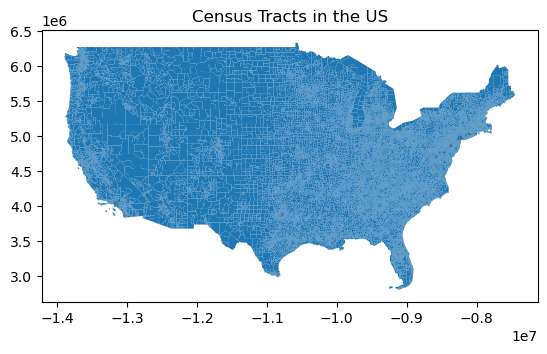

In [13]:
import pygris
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points

# Load the stadium data
stadium_csv_path = '/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/data/mlb_stadiums_geocoded.csv'
stadiums = pd.read_csv(stadium_csv_path)

# Convert to GeoDataFrame
stadiums['geometry'] = stadiums.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
stadiums_gdf = gpd.GeoDataFrame(stadiums, geometry='geometry')

# Ensure the GeoDataFrame has the correct CRS
stadiums_gdf.set_crs(epsg=4326, inplace=True)

# List of state FIPS codes, excluding Alaska and Hawaii
state_fips_codes = [
    '01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '23', 
    '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', 
    '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56'
]

# Initialize an empty GeoDataFrame
all_census_tracts = gpd.GeoDataFrame()

# Loop through each state and pull the census tract data
for fips in state_fips_codes:
    state_tracts = pygris.tracts(state=fips, year=2020)
    all_census_tracts = pd.concat([all_census_tracts, state_tracts], ignore_index=True)

# Reproject the filtered GeoDataFrame to a projected CRS (e.g., EPSG:3857 for Web Mercator)
all_census_tracts = all_census_tracts.to_crs(epsg=3857)
stadiums_gdf = stadiums_gdf.to_crs(epsg=3857)

# Calculate centroids of tracts in the new CRS
all_census_tracts['centroid'] = all_census_tracts.centroid

# Checking the first few rows of the combined data
print(all_census_tracts.head())

# Plotting the combined census tracts
all_census_tracts.plot()
plt.title('Census Tracts in the US')

# Save the plot as a PNG file
plt.savefig('/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/outputs/census_tracts_us.png', dpi=300)

# Show the plot
plt.show()

Calculate proximity

In [14]:
def calculate_nearest(row, destination_gdf, point_column='centroid', dest_point_column='geometry'):
    destination_geom = destination_gdf[dest_point_column].unary_union
    nearest_geom = nearest_points(row[point_column], destination_geom)[1]
    return nearest_geom

# Add nearest stadium geometry to tracts GeoDataFrame
all_census_tracts['nearest_stadium'] = all_census_tracts.apply(calculate_nearest, destination_gdf=stadiums_gdf, axis=1)

# Calculate distance to nearest stadium in meters
all_census_tracts['distance_to_stadium_meters'] = all_census_tracts.apply(
    lambda row: row['centroid'].distance(row['nearest_stadium']),
    axis=1
)

# Convert distance to kilometers
all_census_tracts['distance_to_stadium_km'] = all_census_tracts['distance_to_stadium_meters'] / 1000

# Convert distance to miles
all_census_tracts['distance_to_stadium_miles'] = all_census_tracts['distance_to_stadium_km'] * 0.621371

# Replace NaN values with a high value to show they are far from any stadium
all_census_tracts['distance_to_stadium_miles'].fillna(9999, inplace=True)

In [17]:
# Print the first few rows to check the nearest stadium and distances
print(all_census_tracts[['GEOID', 'centroid', 'nearest_stadium', 'distance_to_stadium_miles']].head())

         GEOID                          centroid  \
0  01045020801  POINT (-9535805.274 3684434.086)   
1  01017954200  POINT (-9491954.257 3874447.997)   
2  01017953800  POINT (-9506637.488 3900439.678)   
3  01017954300  POINT (-9493185.234 3865753.432)   
4  01017954700  POINT (-9481332.806 3864898.811)   

                    nearest_stadium  distance_to_stadium_miles  
0  POINT (-9402994.218 4014136.278)                 220.864232  
1  POINT (-9402994.218 4014136.278)                 102.905312  
2  POINT (-9402994.218 4014136.278)                  95.595953  
3  POINT (-9402994.218 4014136.278)                 107.896719  
4  POINT (-9402994.218 4014136.278)                 104.731443  


In [18]:
# Example to manually verify a few calculations
example_tracts = all_census_tracts.head(5)
for index, row in example_tracts.iterrows():
    print(f"Census Tract: {row['GEOID']}")
    print(f"Centroid: {row['centroid']}")
    print(f"Nearest Stadium: {row['nearest_stadium']}")
    print(f"Distance (miles): {row['distance_to_stadium_miles']}")
    print("-" * 40)

Census Tract: 01045020801
Centroid: POINT (-9535805.274049014 3684434.0863766363)
Nearest Stadium: POINT (-9402994.218410714 4014136.2783532105)
Distance (miles): 220.86423240109184
----------------------------------------
Census Tract: 01017954200
Centroid: POINT (-9491954.256900249 3874447.9965504636)
Nearest Stadium: POINT (-9402994.218410714 4014136.2783532105)
Distance (miles): 102.9053121321199
----------------------------------------
Census Tract: 01017953800
Centroid: POINT (-9506637.488369718 3900439.6780441296)
Nearest Stadium: POINT (-9402994.218410714 4014136.2783532105)
Distance (miles): 95.59595300721276
----------------------------------------
Census Tract: 01017954300
Centroid: POINT (-9493185.23374268 3865753.431993568)
Nearest Stadium: POINT (-9402994.218410714 4014136.2783532105)
Distance (miles): 107.89671899103179
----------------------------------------
Census Tract: 01017954700
Centroid: POINT (-9481332.806301527 3864898.8114194046)
Nearest Stadium: POINT (-94029

/var/folders/jn/z_2qhg3j7875xczdp20z99tw0000gn/T/ipykernel_26379/765260988.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


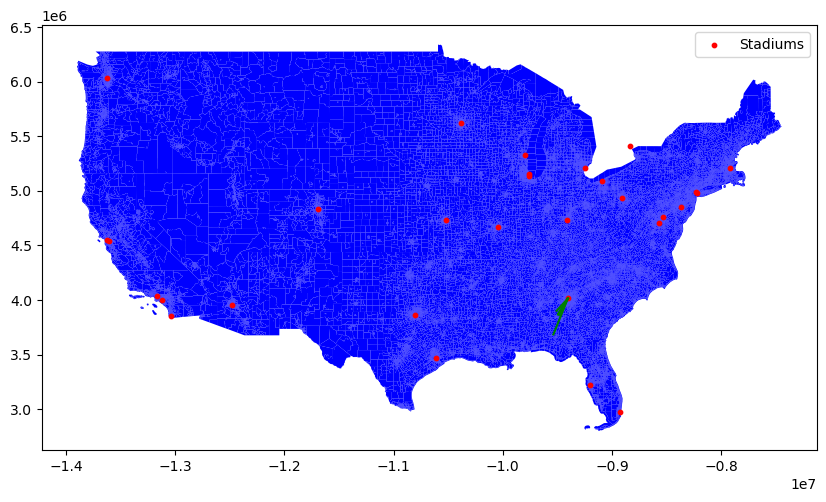

In [19]:
# Plot to visualize centroids and nearest stadiums
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
all_census_tracts.plot(ax=ax, color='blue', markersize=5, label='Census Tract Centroids')
stadiums_gdf.plot(ax=ax, color='red', markersize=10, label='Stadiums')
for index, row in example_tracts.iterrows():
    ax.plot([row['centroid'].x, row['nearest_stadium'].x], [row['centroid'].y, row['nearest_stadium'].y], color='green')

plt.legend()
plt.show()

In [21]:
# Check for missing values
missing_values = all_census_tracts['distance_to_stadium_miles'].isnull().sum()
print(f"Number of missing distance values: {missing_values}")

# Ensure all missing values are filled
all_census_tracts['distance_to_stadium_miles'].fillna(9999, inplace=True)

Number of missing distance values: 0


Summary statistics

In [22]:
# Summary statistics
average_distance_miles = all_census_tracts['distance_to_stadium_miles'].mean()
tracts_within_10_miles = all_census_tracts[all_census_tracts['distance_to_stadium_miles'] <= 10].shape[0]

print(f"Average distance to nearest stadium: {average_distance_miles:.2f} miles")
print(f"Number of tracts within 10 miles of a stadium: {tracts_within_10_miles}")

Average distance to nearest stadium: 127.69 miles
Number of tracts within 10 miles of a stadium: 8851


Project back to geographic coordinates

In [24]:
# Ensure the CRS is set for the GeoDataFrame
if all_census_tracts.crs is None:
    all_census_tracts.set_crs(epsg=3857, inplace=True)

# Reproject the centroids and nearest stadiums back to EPSG:4326
all_census_tracts['centroid_geo'] = all_census_tracts['centroid'].to_crs(epsg=4326)
all_census_tracts['nearest_stadium_geo'] = all_census_tracts['nearest_stadium'].to_crs(epsg=4326)

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

Visualization

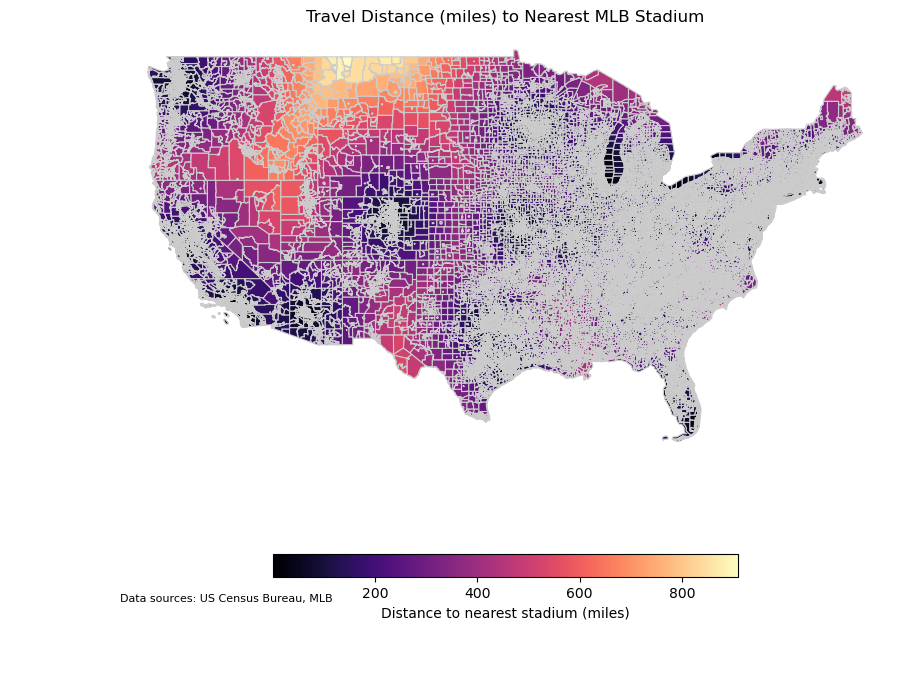

In [16]:
# Add the distance to the GeoDataFrame
all_census_tracts['time'] = all_census_tracts['distance_to_stadium_miles']

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
all_census_tracts.plot(column='time', cmap='magma', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                       legend_kwds={'label': "Distance to nearest stadium (miles)",
                                    'orientation': "horizontal",
                                    'shrink': 0.5})

plt.title("Travel Distance (miles) to Nearest MLB Stadium")

# Annotate with data source
ax.annotate('Data sources: US Census Bureau, MLB', 
            xy=(0.1, 0.1), xycoords='figure fraction',
            fontsize=8, ha='left', va='top')

# Remove axis
ax.set_axis_off()

# Save the plot as a PNG file
plt.savefig('/Users/mitchellhamilton/m-r-ham.github.io/mitchymaps.github.io/projects/mlb-analysis/outputs/distance_to_stadiums.png', dpi=300)

# Show the plot
plt.show()

Merge census data

In [ ]:
from census import Census

# Replace 'YOUR_CENSUS_API_KEY' with your actual Census API key
c = Census("YOUR_CENSUS_API_KEY")

# Specify the year and dataset (ACS5 for American Community Survey 5-year estimates)
year = 2020

# Variables to retrieve (you can add more variables based on your needs)
variables = {
    'B01003_001E': 'total_population',
    'B19013_001E': 'median_household_income',
    'B25077_001E': 'median_home_value',
    'B01002_001E': 'median_age',
    # Add more variables as needed
}

# Function to retrieve data for a state
def get_census_data(state_fips):
    data = c.acs5.state_county_tract(
        list(variables.keys()),
        state_fips,
        Census.ALL,
        Census.ALL,
        year=year
    )
    df = pd.DataFrame(data)
    df.rename(columns=variables, inplace=True)
    return df

# List of state FIPS codes
state_fips_codes = [
    '01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', 
    '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', 
    '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56'
]

# Initialize an empty DataFrame
all_census_data = pd.DataFrame()

# Loop through each state and pull the census data
for fips in state_fips_codes:
    state_data = get_census_data(fips)
    all_census_data = pd.concat([all_census_data, state_data], ignore_index=True)

# Convert to GeoDataFrame and merge with census tracts
all_census_data['GEOID'] = all_census_data['state'] + all_census_data['county'] + all_census_data['tract']
census_tracts_gdf = gpd.GeoDataFrame(all_census_tracts)
merged_gdf = census_tracts_gdf.merge(all_census_data, on='GEOID')

# Save to a file for later use
merged_gdf.to_file('census_tracts_with_data.shp')

# Print the first few rows to check
print(merged_gdf.head())

Visualizations

Visualization 1 - Median Household Income by Census Tract

In [ ]:
import matplotlib.pyplot as plt

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged_gdf.plot(column='median_household_income', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,
                legend_kwds={'label': "Median Household Income",
                             'orientation': "horizontal",
                             'shrink': 0.5})

plt.title("Median Household Income by Census Tract")

# Annotate with data source
ax.annotate('Data sources: US Census Bureau, MLB', 
            xy=(0.1, 0.1), xycoords='figure fraction',
            fontsize=8, ha='left', va='top')

# Remove axis
ax.set_axis_off()

# Save the plot as a PNG file
plt.savefig('median_household_income.png', dpi=300)

# Show the plot
plt.show()